In [1]:
import pandas as pd
import numpy as np
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.contrib.control_flow import scan
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import display, Math
from functions import plot_z
import warnings
warnings.simplefilter('ignore')

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

/Users/satoshan/.pyenv/versions/miniforge3-4.10.3-10/envs/forpymc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Real data
### Period 
1983-2018
### Output gap
Beveridge-Nelson Filter (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

---

In [2]:

data_cpi = pd.read_csv("data/CPIAUCSL.csv")
data_cpi['month'] = pd.to_datetime(data_cpi['DATE']).dt.month
data_cpi = data_cpi[data_cpi['month'] == 1]
data_cpi['year'] = pd.to_datetime(data_cpi['DATE']).dt.year
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi[['year', 'pi']]

data_gap = pd.read_csv("data/BN_filter_GDPC1_annual.csv")
data_gap['year'] = pd.to_datetime(data_gap['date']).dt.year
data_gap['Y'] = data_gap["cycle"]
data_gap = data_gap[["year", "Y"]]

data_Epi = pd.read_csv("data/inflation_expectations_monthly.csv")
data_Epi['month'] = pd.to_datetime(data_Epi['DateTime']).dt.month
data_Epi = data_Epi[data_Epi['month'] == 1]
data_Epi['year'] = pd.to_datetime(data_Epi['DateTime']).dt.year
data_Epi['Epi'] = data_Epi['expected_inflation']
data_Epi = data_Epi[['year', 'Epi']]

data = pd.merge(data_gap, data_Epi, on='year', how='inner')
data = pd.merge(data, data_cpi, on='year', how='inner')
data = data[data['year'] < 2019]
data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data = data[data['year'] > 1982]
year = data["year"].tolist()

# for MCMC
pi = jnp.array(data['pi'])
pi_prev = jnp.array(data['pi_prev'])
pi_expect = jnp.array(data['Epi'])
Y = jnp.array(data['Y'])
Y_prev = jnp.array(data['Y_prev'])

####  Model

"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation

The observed variable $\pi_t$ is the inflation rate, $\text{E}\pi_t$ is the expected inflation rate, and $\text{gap}_t$ is the output gap


In [3]:
warmup= 10000
samples=25000
chains = 4
rng_key = jax.random.PRNGKey(0)

In [4]:
from models import model_0_0
from models import model_0_1
# RUN MCMC
kernel = NUTS(model_0_0)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y)
idata_0_0 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_0_kappa = posterior_samples["kappa"].mean()
model_0_0_beta = posterior_samples["beta"].mean()
model_0_0_text = r"""---
Model 0.0. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t  + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
"""
display(Markdown(model_0_0_text))
result_0_0=rf"""
Result $$\pi_{{t}} = {model_0_0_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_0_0_kappa:.4f}\, Y_t + \epsilon_t$$
"""
display(Markdown(result_0_0))

sample: 100%|██████████| 35000/35000 [00:03<00:00, 9013.75it/s, 3 steps of size 5.80e-01. acc. prob=0.84] 


---
Model 0.0. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t  + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$



Result $$\pi_{t} = 0.9554\, E_t[\pi_{t+1}] + 0.0438\, Y_t + \epsilon_t$$


In [5]:
# RUN MCMC
kernel = NUTS(model_0_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y)
idata_0_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_1_kappa  = posterior_samples["kappa"].mean()
model_0_1_beta = posterior_samples["beta"].mean()
model_0_1_alpha = posterior_samples["alpha"].mean()


model_0_1_text = r"""---
Model 0.1. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
"""
display(Markdown(model_0_1_text))
result_0_1=rf"""
Result $$\pi_{{t}} = {model_0_1_alpha:.4f}\, \pi_{{t-1}} + {model_0_1_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_0_1_kappa:.4f}\, Y_t + \epsilon_t$$
"""
display(Markdown(result_0_1))

sample: 100%|██████████| 35000/35000 [00:04<00:00, 7544.85it/s, 7 steps of size 2.89e-01. acc. prob=0.91] 


---
Model 0.1. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$



Result $$\pi_{t} = -0.0139\, \pi_{t-1} + 0.9695\, E_t[\pi_{t+1}] + 0.0449\, Y_t + \epsilon_t$$


In [6]:
from models import model_1
# RUN MCMC
kernel = NUTS(model_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_1 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_1 = z_mean_1 - 1.96 * z_std     
z_upper_1 = z_mean_1 + 1.96 * z_std  

model_1_kappa = posterior_samples["kappa"].mean()
model_1_theta = posterior_samples["theta"].mean()
model_1_beta  = posterior_samples["beta"].mean()
model_1_rho  = posterior_samples["rho"].mean()

model_1_text = r"""---
Model 1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_1_text))
result_1=rf"""
Result $$\pi_{{t}} = {model_1_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_1_kappa:.4f}\, Y_t - {model_1_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_1_rho:.4f}  z_{{t-1}} + \eta_t$$
"""
display(Markdown(result_1))

sample: 100%|██████████| 35000/35000 [00:10<00:00, 3354.31it/s, 31 steps of size 7.31e-02. acc. prob=0.86]  


---
Model 1. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9545\, E_t[\pi_{t+1}] + 0.0411\, Y_t - 0.3564\, z_t + \epsilon_t$$
$$z_{t} = 0.3257  z_{t-1} + \eta_t$$


In [7]:
from models import model_2
# RUN MCMC
kernel = NUTS(model_2)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_2 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_2 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_2 = z_mean_2 - 1.96 * z_std     
z_upper_2 = z_mean_2 + 1.96 * z_std    

model_2_kappa = posterior_samples["kappa"].mean()
model_2_alpha = posterior_samples["alpha"].mean()
model_2_theta = posterior_samples["theta"].mean()
model_2_beta = posterior_samples["beta"].mean()
model_2_rho = posterior_samples["rho"].mean()

model_2_text = r"""---
Model 2. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_2_text))
result_2=rf"""
Result $$\pi_{{t}} = {model_2_alpha:.4f}\, \pi_{{t-1}} + {model_2_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_2_kappa:.4f}\, Y_t - {model_2_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_2_rho:.4f}  z_{{t-1}} + \eta_t$$
"""
display(Markdown(result_2))

sample: 100%|██████████| 35000/35000 [00:09<00:00, 3579.25it/s, 31 steps of size 1.19e-01. acc. prob=0.77] 


---
Model 2. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho z_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0388\, \pi_{t-1} + 0.9174\, E_t[\pi_{t+1}] + 0.0443\, Y_t - 0.3665\, z_t + \epsilon_t$$
$$z_{t} = 0.3507  z_{t-1} + \eta_t$$


In [8]:
from models import model_3
# RUN MCMC
kernel = NUTS(model_3)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_3 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_3 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_3 = z_mean_3 - 1.96 * z_std     
z_upper_3 = z_mean_3 + 1.96 * z_std  

model_3_kappa = posterior_samples["kappa"].mean()
model_3_theta = posterior_samples["theta"].mean()
model_3_beta = posterior_samples["beta"].mean()
model_3_rho_1 = posterior_samples["rho1"].mean()
model_3_rho_2 = posterior_samples["rho2"].mean()

model_3_text = r"""---
Model 3. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_3_text))
result_3=rf"""
Result $$\pi_{{t}} = {model_3_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_3_kappa:.4f}\, Y_t - {model_3_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_3_rho_1:.4f}  z_{{t-1}} - {model_3_rho_2:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_3))

sample: 100%|██████████| 35000/35000 [00:09<00:00, 3883.10it/s, 63 steps of size 6.88e-02. acc. prob=0.81] 


---
Model 3. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9647\, E_t[\pi_{t+1}] + 0.0396\, Y_t - 0.2076\, z_t + \epsilon_t$$
$$z_{t} = -0.0751  z_{t-1} - 0.2529  Y_{t-1} + \eta_t$$


In [9]:
from models import model_4
# RUN MCMC
kernel = NUTS(model_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_4 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_4 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_4 = z_mean_4 - 1.96 * z_std     
z_upper_4 = z_mean_4 + 1.96 * z_std  

model_4_alpha = posterior_samples["alpha"].mean()
model_4_kappa = posterior_samples["kappa"].mean()
model_4_theta = posterior_samples["theta"].mean()
model_4_beta = posterior_samples["beta"].mean()
model_4_rho_1 = posterior_samples["rho1"].mean()
model_4_rho_2 = posterior_samples["rho2"].mean()
model_4_text = r"""---
Model 4. 
$$
\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_4_text))
result_4=rf"""
Result $$\pi_{{t}} = {model_4_alpha:.4f}\, \pi_{{t-1}} + {model_4_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_4_kappa:.4f}\, Y_t - {model_4_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_4_rho_1:.4f}  z_{{t-1}} - {model_4_rho_2:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_4))

sample: 100%|██████████| 35000/35000 [00:09<00:00, 3523.18it/s, 63 steps of size 7.21e-02. acc. prob=0.81] 


---
Model 4. 
$$
\pi_t = \alpha \pi_{{t-1}}+ \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0148\, \pi_{t-1} + 0.9500\, E_t[\pi_{t+1}] + 0.0429\, Y_t - 0.2273\, z_t + \epsilon_t$$
$$z_{t} = -0.0759  z_{t-1} - 0.2377  Y_{t-1} + \eta_t$$


In [10]:
from models import model_5
# RUN MCMC
kernel = NUTS(model_5)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_5 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_5 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_5 = z_mean_5 - 1.96 * z_std     
z_upper_5 = z_mean_5 + 1.96 * z_std  

model_5_kappa = posterior_samples["kappa"].mean()
model_5_beta = posterior_samples["beta"].mean()
model_5_theta = posterior_samples["theta"].mean()
model_5_rho_1 = posterior_samples["rho1"].mean()
model_5_rho_2 = posterior_samples["rho2"].mean()
model_5_rho_3 = posterior_samples["rho3"].mean()

model_5_text = r"""---
Model 5. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_5_text))
result_5=rf"""
Result $$\pi_{{t}} = {model_5_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_5_kappa:.4f}\, Y_t - {model_5_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_5_rho_1:.4f}  z_{{t-1}} + {model_5_rho_2:.4f}  \pi_{{t-1}} - {model_5_rho_3:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_5))

sample: 100%|██████████| 35000/35000 [00:13<00:00, 2574.95it/s, 63 steps of size 3.37e-02. acc. prob=0.84]  


---
Model 5. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9513\, E_t[\pi_{t+1}] + 0.0433\, Y_t - 0.1261\, z_t + \epsilon_t$$
$$z_{t} = 0.0011  z_{t-1} + -0.0711  \pi_{t-1} - 0.3111  Y_{t-1} + \eta_t$$


In [11]:
from models import model_6
# RUN MCMC
kernel = NUTS(model_6)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_6 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_6 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_6 = z_mean_6 - 1.96 * z_std     
z_upper_6 = z_mean_6 + 1.96 * z_std  

model_6_alpha = posterior_samples["alpha"].mean()
model_6_kappa = posterior_samples["kappa"].mean()
model_6_beta = posterior_samples["beta"].mean()
model_6_theta = posterior_samples["theta"].mean()
model_6_rho_1 = posterior_samples["rho1"].mean()
model_6_rho_2 = posterior_samples["rho2"].mean()
model_6_rho_3 = posterior_samples["rho3"].mean()
model_6_text = r"""---
Model 6. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_6_text))
result_6=rf"""
Result $$\pi_{{t}} = {model_6_alpha:.4f}\, \pi_{{t-1}} + {model_6_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_6_kappa:.4f}\, Y_t - {model_6_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_6_rho_1:.4f}  z_{{t-1}} + {model_6_rho_2:.4f}  \pi_{{t-1}} - {model_6_rho_3:.4f}  Y_{{t-1}} + \eta_t$$
"""
display(Markdown(result_6))

sample: 100%|██████████| 35000/35000 [00:10<00:00, 3243.64it/s, 63 steps of size 7.25e-02. acc. prob=0.64] 


---
Model 6. 
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \pi_{{t-1}} + \rho_3 \hat{Y}_{t-1} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.1060\, \pi_{t-1} + 0.9001\, E_t[\pi_{t+1}] + 0.0456\, Y_t - 0.2152\, z_t + \epsilon_t$$
$$z_{t} = -0.1295  z_{t-1} + 0.2373  \pi_{t-1} - 0.2648  Y_{t-1} + \eta_t$$


In [12]:
from models import model_7
# RUN MCMC
kernel = NUTS(model_7)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_7 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_7 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_7 = z_mean_7 - 1.96 * z_std     
z_upper_7 = z_mean_7 + 1.96 * z_std  

model_7_kappa = posterior_samples["kappa"].mean()
model_7_theta = posterior_samples["theta"].mean()
model_7_beta  = posterior_samples["beta"].mean()
model_7_rho_1 = posterior_samples["rho1"].mean()
model_7_rho_2 = posterior_samples["rho2"].mean()
model_7_text = r"""---
Model 7. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_7_text))
result_7=rf"""
Result $$\pi_{{t}} = {model_7_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_7_kappa:.4f}\, Y_t - {model_7_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_7_rho_1:.4f}  z_{{t-1}} - {model_7_rho_2:.4f}  Y_{{t}} + \eta_t$$
"""
display(Markdown(result_7))

sample: 100%|██████████| 35000/35000 [00:09<00:00, 3537.74it/s, 59 steps of size 7.59e-02. acc. prob=0.77]  


---
Model 7. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} + \rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9583\, E_t[\pi_{t+1}] + 0.0420\, Y_t - 0.1930\, z_t + \epsilon_t$$
$$z_{t} = -0.0774  z_{t-1} - 0.2234  Y_{t} + \eta_t$$


In [13]:
from models import model_8
# RUN MCMC
kernel = NUTS(model_8)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_8 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_8 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_8 = z_mean_8 - 1.96 * z_std     
z_upper_8 = z_mean_8 + 1.96 * z_std  

model_8_kappa = posterior_samples["kappa"].mean()
model_8_theta = posterior_samples["theta"].mean()
model_8_alpha = posterior_samples["alpha"].mean()
model_8_beta  = posterior_samples["beta"].mean()
model_8_rho_1 = posterior_samples["rho1"].mean()
model_8_rho_2 = posterior_samples["rho2"].mean()
model_8_text = r"""---
Model 8. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} - rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_8_text))
result_8=rf"""
Result $$\pi_{{t}} = {model_8_alpha:.4f}\, \pi_{{t-1}} + {model_8_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_8_kappa:.4f}\, Y_t - {model_8_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_8_rho_1:.4f}\, z_{{t-1}} - {model_8_rho_2:.4f}  Y_{{t}} + \eta_t$$
"""
display(Markdown(result_8))

sample: 100%|██████████| 35000/35000 [00:10<00:00, 3396.92it/s, 31 steps of size 7.26e-02. acc. prob=0.79] 


---
Model 8. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho_1 z_{{t-1}} - rho_2 \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0171\, \pi_{t-1} + 0.9414\, E_t[\pi_{t+1}] + 0.0414\, Y_t - 0.1921\, z_t + \epsilon_t$$
$$z_{t} = -0.0839\, z_{t-1} - 0.2214  Y_{t} + \eta_t$$


In [14]:
from models import model_9
# RUN MCMC
kernel = NUTS(model_9)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_9 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_9 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_9 = z_mean_9 - 1.96 * z_std     
z_upper_9 = z_mean_9 + 1.96 * z_std  

model_9_kappa = posterior_samples["kappa"].mean()
model_9_theta = posterior_samples["theta"].mean()
model_9_beta  = posterior_samples["beta"].mean()
model_9_rho   = posterior_samples["rho"].mean()

model_9_text = r"""---
Model 9. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_9_text))
result_9=rf"""
Result $$\pi_{{t}} = {model_9_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_9_kappa:.4f}\, Y_t - {model_9_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = - {model_9_rho:.4f}  Y_{{t}} + \eta_t$$
"""
display(Markdown(result_9))

sample: 100%|██████████| 35000/35000 [00:08<00:00, 4208.32it/s, 39 steps of size 6.77e-02. acc. prob=0.80]  


---
Model 9. 
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \rho \hat{Y}_{t} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.9514\, E_t[\pi_{t+1}] + 0.0395\, Y_t - 0.1898\, z_t + \epsilon_t$$
$$z_{t} = - 0.1921  Y_{t} + \eta_t$$


In [15]:
from models import model_10
# RUN MCMC
kernel = NUTS(model_10)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_10 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_10 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_10 = z_mean_10 - 1.96 * z_std     
z_upper_10 = z_mean_10 + 1.96 * z_std  

model_10_kappa = posterior_samples["kappa"].mean()
model_10_theta = posterior_samples["theta"].mean()
model_10_alpha = posterior_samples["alpha"].mean()
model_10_beta  = posterior_samples["beta"].mean()
model_10_rho   = posterior_samples["rho"].mean()
model_10_text = r"""---
Model 10. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta  \hat{z}_{t} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t =  \rho \hat{Y}_{t} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
"""
display(Markdown(model_10_text))
result_10=rf"""
Result $$\pi_{{t}} = {model_10_alpha:.4f}\, \pi_{{t-1}} + {model_10_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_10_kappa:.4f}\, Y_t - {model_10_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = - {model_10_rho:.4f}  Y_{{t}} + \eta_t$$
"""
display(Markdown(result_10))

sample: 100%|██████████| 35000/35000 [00:08<00:00, 4052.59it/s, 31 steps of size 9.25e-02. acc. prob=0.76] 


---
Model 10. 
$$
\pi_t = \alpha \pi_{t-1} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta  \hat{z}_{t} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t =  \rho \hat{Y}_{t} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$



Result $$\pi_{t} = 0.0006\, \pi_{t-1} + 0.9579\, E_t[\pi_{t+1}] + 0.0415\, Y_t - 0.2127\, z_t + \epsilon_t$$
$$z_{t} = - 0.2102  Y_{t} + \eta_t$$


## Results

## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
$$
\text{lppd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$

'WAIC'

'Leave One Out cross validation'

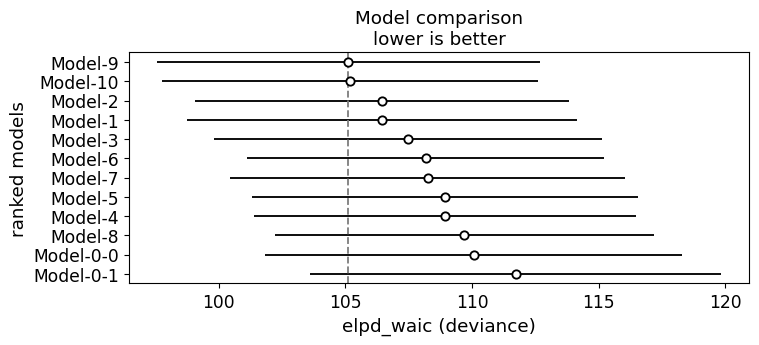

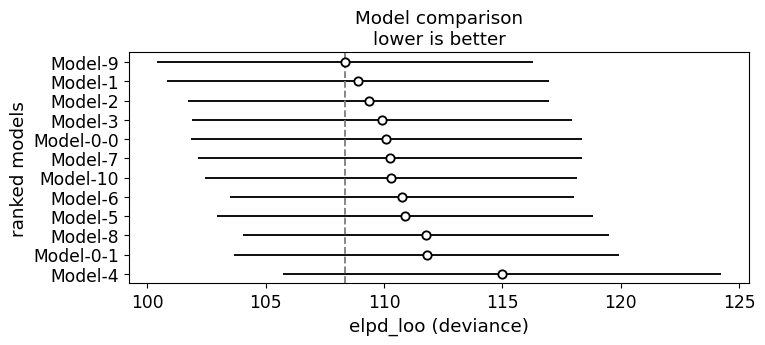

In [16]:
display("WAIC")
dict_idata = {'Model-0-0':idata_0_0,'Model-0-1':idata_0_1,'Model-1':idata_1, 'Model-2':idata_2,'Model-3':idata_3, 'Model-4':idata_4,
              'Model-5':idata_5,'Model-6':idata_6, 'Model-7':idata_7,'Model-8':idata_8, 'Model-9':idata_9, 'Model-10':idata_10}
df_waic = az.compare(dict_idata, ic='waic', scale='deviance')
az.plot_compare(df_waic, figsize=(8, 3));

display("Leave One Out cross validation")
df_loo = az.compare(dict_idata, ic='loo', scale='deviance')
az.plot_compare(df_loo, figsize=(8, 3));

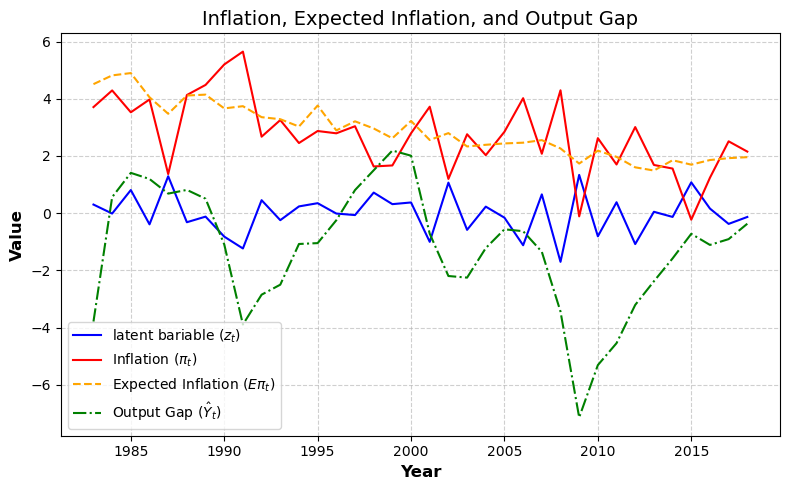

In [17]:
# data
plt.figure(figsize=(8, 5))
plt.plot(year, z_mean_1, label=r'latent bariable $(z_{t})$', linestyle='-', color='blue')       
plt.plot(year, data["pi"], label=r'Inflation $(\pi_{t})$', linestyle='-', color='red')       
plt.plot(year, data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')    
plt.plot(year, data["Y"], label='Output Gap $(\hat{Y}_{t})$', linestyle='-.', color='green') 
plt.xlabel('Year', fontsize=12, weight='bold')
plt.ylabel('Value', fontsize=12, weight='bold')
plt.title('Inflation, Expected Inflation, and Output Gap', fontsize=14)
plt.legend(fontsize=10, frameon=True, loc='lower left', fancybox=True)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

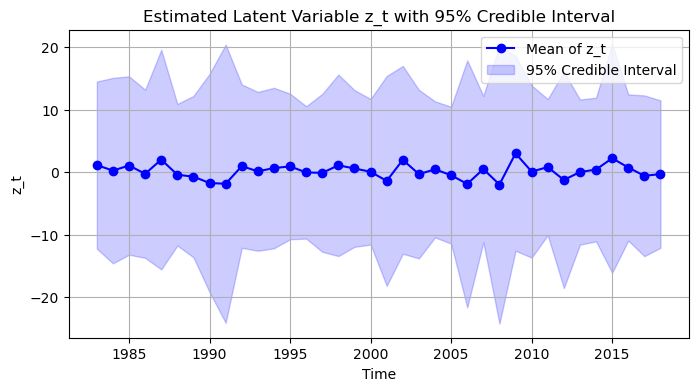

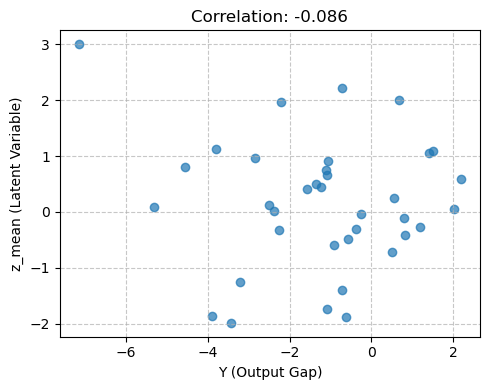

In [18]:
plot_z(year, z_mean_10,z_lower_10, z_upper_10, Y)

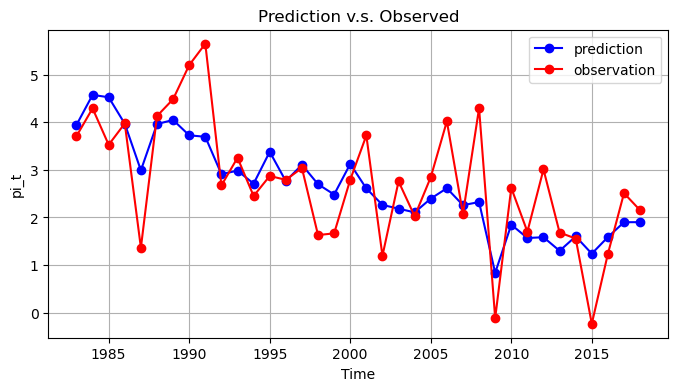

Bayesian R^2: 0.5407536625862122


In [19]:
kappa_mean_value = float(idata_9.posterior["kappa"].mean(dim=["chain", "draw"]))
beta_mean_value = float(idata_9.posterior["beta"].mean(dim=["chain", "draw"]))
rho_mean_value = float(idata_9.posterior["rho"].mean(dim=["chain", "draw"]))
theta_mean_value = float(idata_9.posterior["theta"].mean(dim=["chain", "draw"]))
# model fit
pi_pred = beta_mean_value * pi_expect + kappa_mean_value * Y -  theta_mean_value * z_mean_9

var_pi_pred = np.var(pi_pred)
var_pi_resid = np.var(pi - pi_pred)
r2 =  var_pi_pred / (var_pi_pred + var_pi_resid)

plt.figure(figsize=(8, 4))
plt.plot(year, pi_pred, label="prediction", color="blue", marker="o")
plt.plot(year, pi, label="observation", color="red", marker="o")
plt.title("Prediction v.s. Observed")
plt.xlabel("Time")
plt.ylabel("pi_t")
plt.legend()
plt.grid(True)
plt.show()
print(f"Bayesian R^2: {r2}")

In [20]:
from IPython.display import HTML
df_list = []
for model_name, idata in dict_idata.items():
    summary = az.summary(idata, var_names=["kappa"], kind="stats")
    summary["model"] = model_name
    df_list.append(summary)
summary_df = pd.concat(df_list)
summary_df = summary_df[["model","mean"]]
summary_df

,model,mean
kappa,Model-0-0,0.044
kappa,Model-0-1,0.045
kappa,Model-1,0.041
kappa,Model-2,0.044
kappa,Model-3,0.040
kappa,Model-4,0.043
kappa,Model-5,0.043
kappa,Model-6,0.046
kappa,Model-7,0.042
kappa,Model-8,0.041


In [21]:
from IPython.display import Markdown, display
dict_eq = {'Model-0-0':result_0_0,'Model-0-1':result_0_1,'Model-1':result_1, 'Model-2':result_2,'Model-3':result_3, 'Model-4':result_4,
              'Model-5':result_5,'Model-6':result_6, 'Model-7':result_7,'Model-8':result_8, 'Model-9':result_9, 'Model-10':result_10}
markdown_lines = [
    "| Model Name | Equation |",
    "|-----------|----------|"
]

for model_name, eq_text in dict_eq.items():
    eq_text_escaped = eq_text.replace("|", "\\|")
    eq_text_escaped = eq_text_escaped.replace("\n", "<br>")
    eq_text_escaped = eq_text_escaped.replace("---", "") 
    eq_text_escaped = eq_text_escaped.replace("Result", "")  
    eq_text_escaped = eq_text_escaped.replace("Model", "")  
    markdown_lines.append(f"| {model_name} | {eq_text_escaped} |")

markdown_table = "\n".join(markdown_lines)
display(Markdown(markdown_table))

| Model Name | Equation |
|-----------|----------|
| Model-0-0 | <br> $$\pi_{t} = 0.9554\, E_t[\pi_{t+1}] + 0.0438\, Y_t + \epsilon_t$$<br> |
| Model-0-1 | <br> $$\pi_{t} = -0.0139\, \pi_{t-1} + 0.9695\, E_t[\pi_{t+1}] + 0.0449\, Y_t + \epsilon_t$$<br> |
| Model-1 | <br> $$\pi_{t} = 0.9545\, E_t[\pi_{t+1}] + 0.0411\, Y_t - 0.3564\, z_t + \epsilon_t$$<br>$$z_{t} = 0.3257  z_{t-1} + \eta_t$$<br> |
| Model-2 | <br> $$\pi_{t} = 0.0388\, \pi_{t-1} + 0.9174\, E_t[\pi_{t+1}] + 0.0443\, Y_t - 0.3665\, z_t + \epsilon_t$$<br>$$z_{t} = 0.3507  z_{t-1} + \eta_t$$<br> |
| Model-3 | <br> $$\pi_{t} = 0.9647\, E_t[\pi_{t+1}] + 0.0396\, Y_t - 0.2076\, z_t + \epsilon_t$$<br>$$z_{t} = -0.0751  z_{t-1} - 0.2529  Y_{t-1} + \eta_t$$<br> |
| Model-4 | <br> $$\pi_{t} = 0.0148\, \pi_{t-1} + 0.9500\, E_t[\pi_{t+1}] + 0.0429\, Y_t - 0.2273\, z_t + \epsilon_t$$<br>$$z_{t} = -0.0759  z_{t-1} - 0.2377  Y_{t-1} + \eta_t$$<br> |
| Model-5 | <br> $$\pi_{t} = 0.9513\, E_t[\pi_{t+1}] + 0.0433\, Y_t - 0.1261\, z_t + \epsilon_t$$<br>$$z_{t} = 0.0011  z_{t-1} + -0.0711  \pi_{t-1} - 0.3111  Y_{t-1} + \eta_t$$<br> |
| Model-6 | <br> $$\pi_{t} = 0.1060\, \pi_{t-1} + 0.9001\, E_t[\pi_{t+1}] + 0.0456\, Y_t - 0.2152\, z_t + \epsilon_t$$<br>$$z_{t} = -0.1295  z_{t-1} + 0.2373  \pi_{t-1} - 0.2648  Y_{t-1} + \eta_t$$<br> |
| Model-7 | <br> $$\pi_{t} = 0.9583\, E_t[\pi_{t+1}] + 0.0420\, Y_t - 0.1930\, z_t + \epsilon_t$$<br>$$z_{t} = -0.0774  z_{t-1} - 0.2234  Y_{t} + \eta_t$$<br> |
| Model-8 | <br> $$\pi_{t} = 0.0171\, \pi_{t-1} + 0.9414\, E_t[\pi_{t+1}] + 0.0414\, Y_t - 0.1921\, z_t + \epsilon_t$$<br>$$z_{t} = -0.0839\, z_{t-1} - 0.2214  Y_{t} + \eta_t$$<br> |
| Model-9 | <br> $$\pi_{t} = 0.9514\, E_t[\pi_{t+1}] + 0.0395\, Y_t - 0.1898\, z_t + \epsilon_t$$<br>$$z_{t} = - 0.1921  Y_{t} + \eta_t$$<br> |
| Model-10 | <br> $$\pi_{t} = 0.0006\, \pi_{t-1} + 0.9579\, E_t[\pi_{t+1}] + 0.0415\, Y_t - 0.2127\, z_t + \epsilon_t$$<br>$$z_{t} = - 0.2102  Y_{t} + \eta_t$$<br> |